# Compare object detection and panoptic segmentation

Understand when to use bounding boxes versus pixel-level masks for image analysis.

**What's in this recipe:**
- Run object detection to get bounding boxes and labels
- Run panoptic segmentation to get pixel-level masks
- Compare outputs side-by-side to understand the tradeoffs


## Problem

You need to analyze objects in images, but there are two approaches:

| Approach | Output | Example |
|----------|--------|---------|
| Object Detection | Bounding boxes | "Car at [100, 200, 300, 400]" |
| Panoptic Segmentation | Pixel masks | "These 45,000 pixels are a car" |

Which should you use? Detection is faster but approximate. Segmentation is slower but precise.


## Solution

You run both approaches on the same images using DETR models and compare the results. This helps you understand which approach fits your use case.

### Setup


In [ ]:
%pip install -qU pixeltable torch transformers


In [ ]:
import pixeltable as pxt
from pixeltable.functions.huggingface import detr_for_object_detection, detr_for_segmentation
import pixeltable.functions as pxtf


### Load images


In [23]:
pxt.drop_dir('detection_vs_seg', force=True)
pxt.create_dir('detection_vs_seg')


Created directory 'detection_vs_seg'.


In [24]:
images = pxt.create_table('detection_vs_seg.images', {'image': pxt.Image})

images.insert([
    {'image': 'https://raw.githubusercontent.com/pixeltable/pixeltable/release/docs/resources/images/000000000034.jpg'},
    {'image': 'https://raw.githubusercontent.com/pixeltable/pixeltable/release/docs/resources/images/000000000049.jpg'},
])


Created table 'images'.
Inserting rows into `images`: 2 rows [00:00, 1362.45 rows/s]
Inserted 2 rows with 0 errors.


2 rows inserted, 4 values computed.

### Run object detection

The built-in `detr_for_object_detection` function returns bounding boxes, labels, and confidence scores.

**Parameters:**
- `model_id`: DETR variant (`facebook/detr-resnet-50` or `facebook/detr-resnet-101`)
- `threshold`: Confidence threshold (0.0-1.0). Higher = fewer but more confident detections

**Output:**
```python
{'boxes': [[x1, y1, x2, y2], ...], 'scores': [0.98, ...], 'label_text': ['person', ...]}
```


image,detr_for_object_detection
,"{""scores"": [1.], ""labels"": [24], ""label_text"": [""zebra""], ""boxes"": [[-0.231, 19.502, 439.539, 400.323]]}"

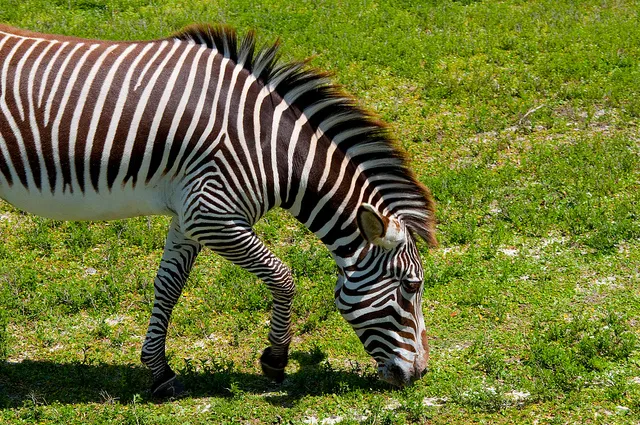

In [25]:
# Test detection on first image
images.select(
    images.image,
    detr_for_object_detection(images.image, model_id='facebook/detr-resnet-50', threshold=0.7)
).head(1)


In [26]:
# Commit: save detections as computed column
images.add_computed_column(
    detections=detr_for_object_detection(images.image, model_id='facebook/detr-resnet-50', threshold=0.7)
)


Added 2 column values with 0 errors.


2 rows updated, 2 values computed.

### Visualize detection results


In [ ]:
# Add visualization column with visible styling
images.add_computed_column(
    detection_viz=pxtf.vision.draw_bounding_boxes(
        images.image,
        boxes=images.detections.boxes,
        labels=images.detections.label_text,
        fill=True,
        width=3
    )
)


Added 2 column values with 0 errors.


2 rows updated, 2 values computed.

image,detection_viz,detections_labeltext
,,"[""zebra""]"
,,"[""person"", ""person"", ""person"", ""person"", ""horse"", ""person"", ""potted plant"", ""person"", ""person"", ""horse""]"

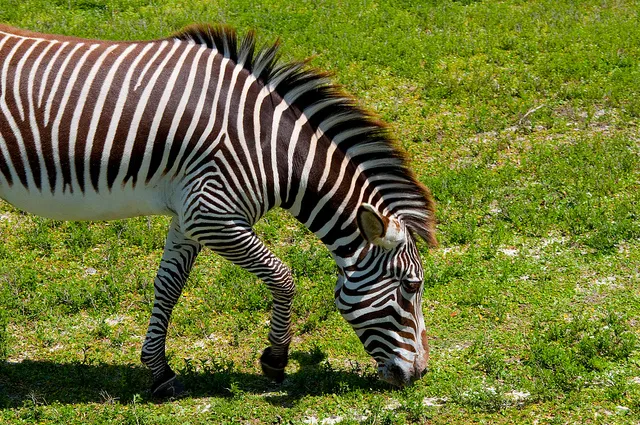
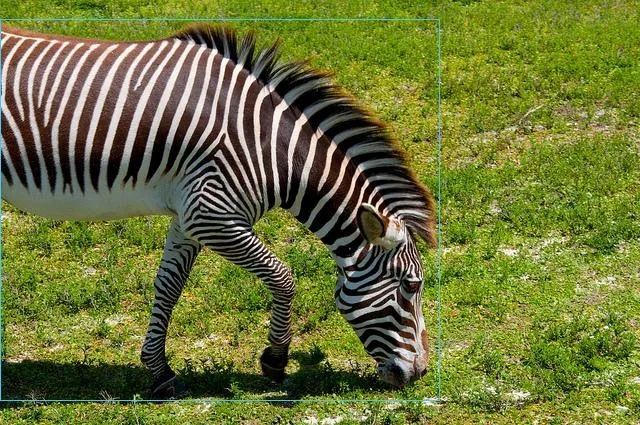
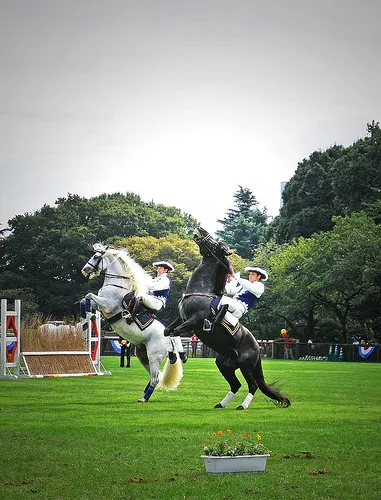
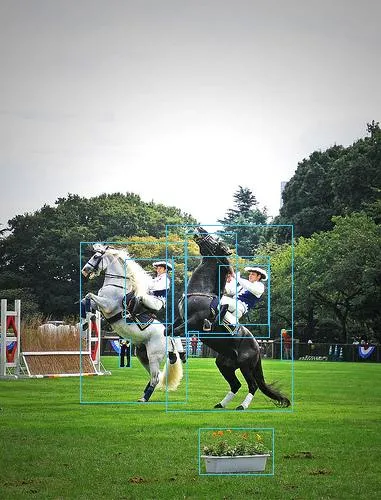

In [28]:
# View original, annotated, and labels
images.select(images.image, images.detection_viz, images.detections.label_text).show()


### Run panoptic segmentation

The built-in `detr_for_segmentation` function returns pixel-level masks with segment metadata.

**Parameters:**
- `model_id`: DETR panoptic model (`facebook/detr-resnet-50-panoptic`)
- `threshold`: Confidence threshold (0.0-1.0). Higher = fewer but more confident segments

**Key concepts:**
- **Things**: Countable objects (people, cars) - each instance gets its own segment
- **Stuff**: Amorphous regions (sky, grass) - one segment per class

**Output:**
```python
{'num_segments': 5, 'segments': [{'id': 1, 'label': 17, 'label_text': 'person', 'area': 45000, 'is_thing': True}, ...]}
```


In [ ]:
# Test segmentation on first image
images.select(
    images.image,
    detr_for_segmentation(images.image, model_id='facebook/detr-resnet-50-panoptic', threshold=0.85)
).head(1)


In [ ]:
# Commit: save segmentation as computed column
images.add_computed_column(
    segmentation=detr_for_segmentation(images.image, model_id='facebook/detr-resnet-50-panoptic', threshold=0.85)
)


In [ ]:
# Add visualization column using built-in draw_segmentation_masks
images.add_computed_column(
    seg_viz=pxtf.vision.draw_segmentation_masks(images.image, images.segmentation, alpha=0.5)
)


image,seg_viz,segmentation
,,"{""segments"": [{""area"": 177758, ""label"": ""LABEL_193"", ""is_thing"": false}, {""area"": 94242, ""label"": ""zebra"", ""is_thing"": true}], ""num_segments"": 2}"
,,"{""segments"": [{""area"": 210, ""label"": ""person"", ""is_thing"": true}, {""area"": 8498, ""label"": ""LABEL_185"", ""is_thing"": false}, {""area"": 1036, ""label"": ""person"", ""is_thing"": true}, {""area"": 7624, ""label"": ""horse"", ""is_thing"": true}, {""area"": 73030, ""label"": ""LABEL_187"", ""is_thing"": false}, {""area"": 309, ""label"": ""person"", ""is_thing"": true}, {""area"": 2518, ""label"": ""potted plant"", ""is_thing"": true}, {""area"": 42076, ""label"": ""LABEL_184"", ""is_thing"": false}, {""area"": 7072, ""label"": ""horse"", ""is_thing"": true}, {""area"": 1667, ""label"": ""person"", ""is_thing"": true}, {""area"": 46460, ""label"": ""LABEL_193"", ""is_thing"": false}], ""num_segments"": 11}"

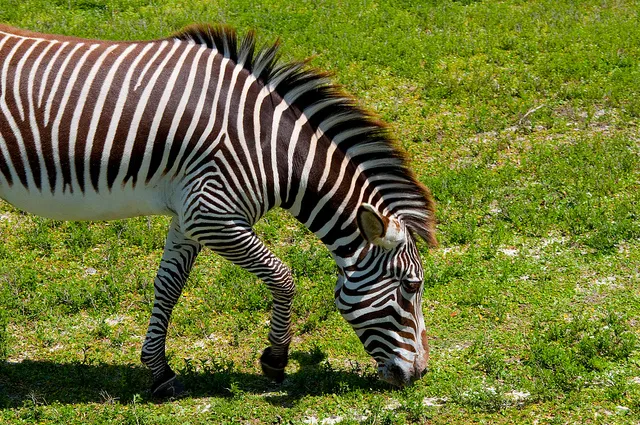
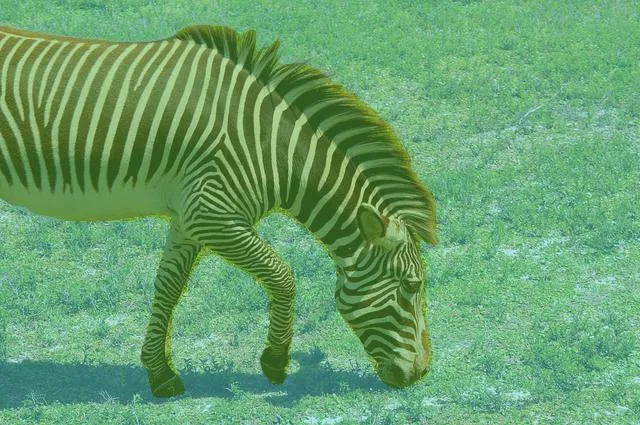
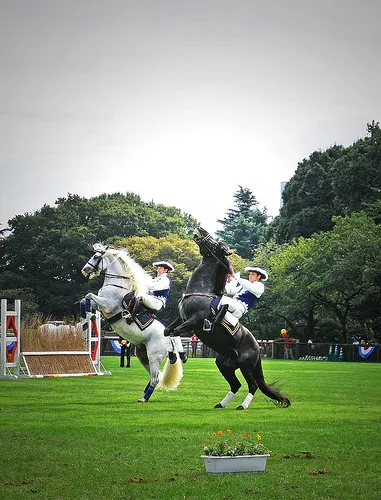
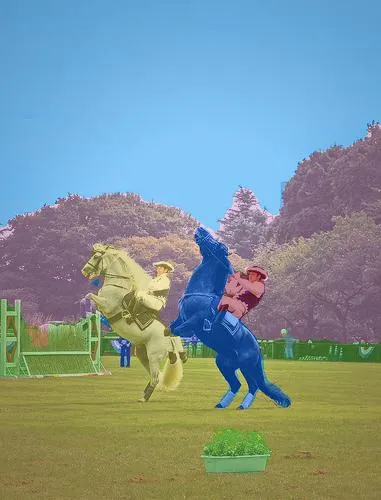

In [32]:
# View segmentation results
images.select(images.image, images.seg_viz, images.segmentation).show()


### Compare side-by-side

image,detection_viz,seg_viz,detections_labeltext,segmentation_numsegments
,,,"[""zebra""]",2
,,,"[""person"", ""person"", ""person"", ""person"", ""horse"", ""person"", ""potted plant"", ""person"", ""person"", ""horse""]",11

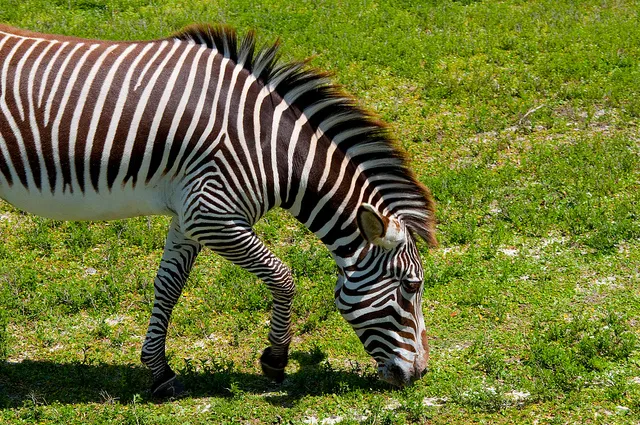
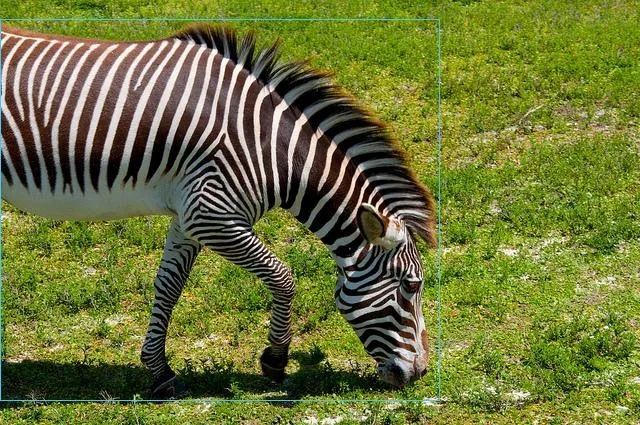
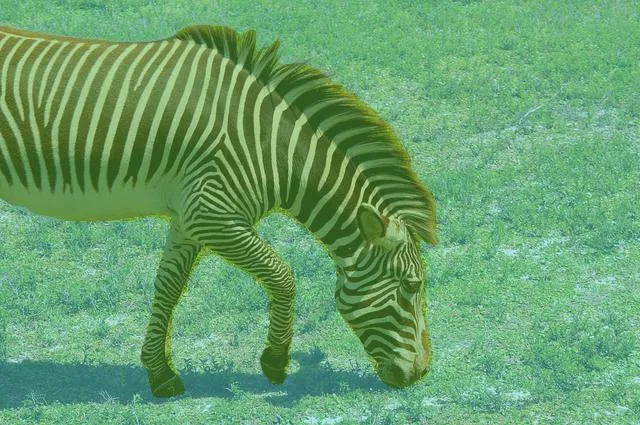
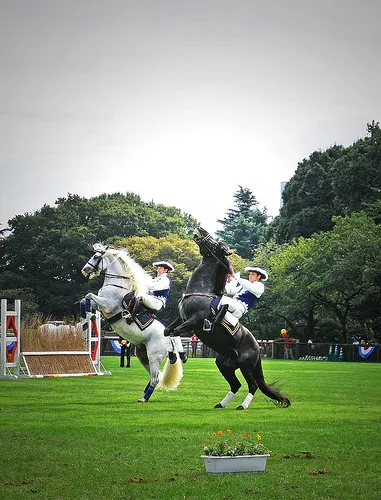
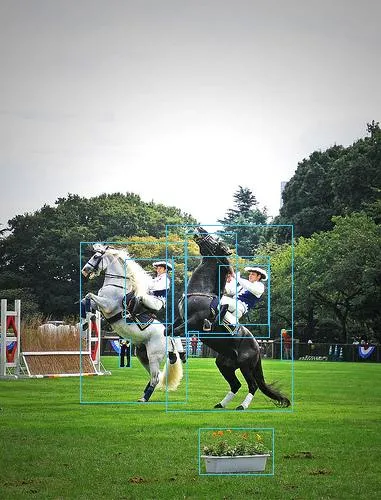
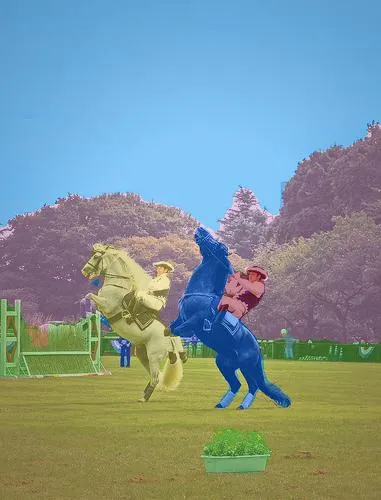

In [33]:
# Compare detection boxes vs segmentation masks
images.select(
    images.image,
    images.detection_viz,
    images.seg_viz,
    images.detections.label_text,
    images.segmentation.num_segments
).show()


image,num_detections,num_segments
,1,2
,10,11

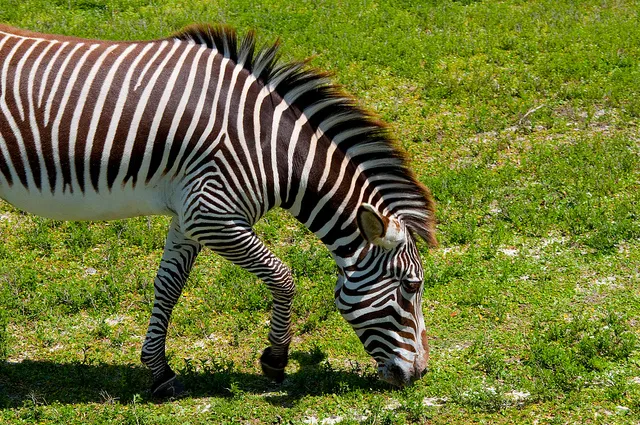
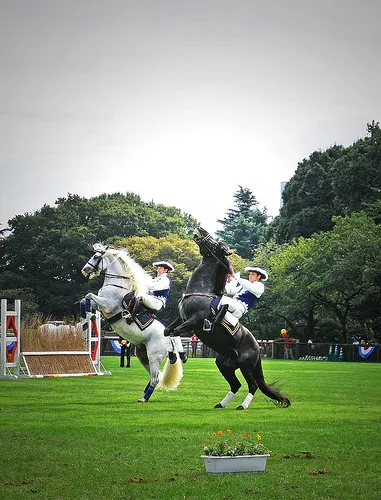

In [34]:
# Query: count objects per image
images.select(
    images.image,
    num_detections=images.detections.boxes.apply(len, col_type=pxt.Int),
    num_segments=images.segmentation.num_segments
).show()


## Explanation

Detection gives fast, approximate locations. Segmentation gives slow, precise boundaries. The choice depends on your application.

### Capability comparison

| Use Case | Detection | Segmentation |
|----------|-----------|--------------|
| Object counting | Yes | Yes |
| Object localization | Yes | Yes |
| Precise boundaries | No | Yes |
| Background removal | No | Yes |
| Scene composition | No | Yes |
| Speed priority | Yes | No |

### Performance tradeoffs

| Metric | Detection | Segmentation |
|--------|-----------|--------------|
| Inference time | ~100ms | ~200ms |
| Output size | ~1KB | ~1MB+ |

### When to use each

**Choose detection when:**
- You need to know *what* objects are present and *where* (approximately)
- Speed matters (detection is 2x faster)
- You need search, filtering, or counting
- Bounding boxes suffice for visualization

**Choose segmentation when:**
- You need *exact* object boundaries (pixel-perfect masks)
- You're doing image editing, compositing, or AR
- You need to measure actual object area/coverage
- You want scene composition analysis (what % is sky vs buildings)


## See also

- [Detect objects in images](./img-detect-objects.ipynb) - Object detection with YOLOX
- [DETR documentation](https://huggingface.co/docs/transformers/model_doc/detr) - Hugging Face model docs
